In [1]:
from torch.nn.functional import gumbel_softmax
import torch
import numpy as np
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
from matplotlib import cm

In [7]:
nr_samples = 100000
x = np.random.sample((nr_samples, 2))
y = np.zeros((nr_samples, 2))
for i in range(nr_samples):
    if (0.3 < x[i, 0] < 0.7) and (0.3 < x[i, 1] < 0.7):
        y[i][1] = 1
    else:
        y[i][0] = 1
print(f'nr label=0: {len(np.where(y[:,1]==1)[0])}')
print(f'nr label=1: {len(np.where(y[:,0]==1)[0])}')

nr label=0: 15916
nr label=1: 84084


In [8]:
dataset = TensorDataset(torch.Tensor(x), torch.Tensor(y))
training_data_size = int(0.95 * len(dataset))
test_size = len(dataset) - training_data_size
training_dataset, test_dataset = torch.utils.data.random_split(dataset,
                                                               [training_data_size, test_size])
training_dataloader = DataLoader(training_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32)

In [9]:
NN = torch.nn.Sequential(
    nn.Linear(2, 6),
    nn.ReLU(),
    nn.Linear(6, 2),
    nn.Softmax(dim=1)
)
print(list(NN.named_modules()))

[('', Sequential(
  (0): Linear(in_features=2, out_features=6, bias=True)
  (1): ReLU()
  (2): Linear(in_features=6, out_features=2, bias=True)
  (3): Softmax(dim=1)
)), ('0', Linear(in_features=2, out_features=6, bias=True)), ('1', ReLU()), ('2', Linear(in_features=6, out_features=2, bias=True)), ('3', Softmax(dim=1))]


In [10]:
linear_1 = dict(NN.named_modules())['0']
linear_1.bias.data = torch.zeros(linear_1.bias.size())
linear_1.weight.data = torch.ones(linear_1.weight.size())
linear_1.weight.data[:, 1] = 0
print(list(linear_1.parameters()))

[Parameter containing:
tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]], requires_grad=True), Parameter containing:
tensor([0., 0., 0., 0., 0., 0.], requires_grad=True)]


In [185]:
linear_2 = dict(NN.named_modules())['2']
linear_2.bias.data = torch.Tensor([3,0])
print(list(linear_2.parameters()))


[Parameter containing:
tensor([[ 0.1830, -0.3241,  0.2750, -0.0922, -0.3912,  0.3944],
        [ 0.2515,  0.1512,  0.4078, -0.2297,  0.2090,  0.3201]],
       requires_grad=True), Parameter containing:
tensor([3., 0.], requires_grad=True)]


In [192]:
def train_nn(NN, training_dataloader, test_dataloader, nr_epochs=10):
    NN.train()
    optimizer = torch.optim.Adam(NN.parameters(),
                           lr=0.001)
    loss_f = nn.BCELoss()
    for epoch in range(nr_epochs):
        losses = np.zeros(len(training_dataloader))
        for i, batch in enumerate(training_dataloader):
            optimizer.zero_grad()
            predicted_labels = NN(batch[0])
            loss = loss_f(predicted_labels, batch[1])
            loss.backward()
            optimizer.step()
            losses[i] = loss
        print(f'loss in epoch {epoch}: {np.mean(losses)}')
        test_nn(NN, test_dataloader)

In [193]:
def test_nn(NN, test_dataloader):
    NN.eval()

    test_loss = 0
    correctly_predicted = 0
    nr_predicted_ones = 0
    nr_real_ones = 0
    nr_correctly_predicted_ones = 0
    for i, batch in enumerate(test_dataloader):

        predicted_labels = NN(batch[0])
        correctly_predicted += len(torch.where(predicted_labels.argmax(dim=1) == batch[1].argmax(dim=1))[0])
        predicted_ones = torch.where(predicted_labels.argmax(dim=1) == 1)[0]
        nr_predicted_ones += len(predicted_ones)
        real_ones = torch.where(batch[1].argmax(dim=1) == 1)[0]
        nr_real_ones += len(real_ones)
        #nr_correctly_predicted_ones += len(torch.where(real_ones == predicted_ones))
        label_indices = predicted_labels.argmax(dim=1)
        test_loss += loss_f(predicted_labels, batch[1])

    accuracy = correctly_predicted / len(test_dataloader.dataset)
    print('accuracy:',  accuracy)
    print(f'predicted_ones: {nr_predicted_ones}')

In [194]:
train_nn(NN, training_dataloader, test_dataloader)

loss in epoch 0: 0.4178300775462128
accuracy: 0.8382
predicted_ones: 0
loss in epoch 1: 0.3589023327486282
accuracy: 0.8382
predicted_ones: 0
loss in epoch 2: 0.33032972426326185
accuracy: 0.828
predicted_ones: 53
loss in epoch 3: 0.3153661666795461
accuracy: 0.8284
predicted_ones: 149
loss in epoch 4: 0.2908964092382277
accuracy: 0.8792
predicted_ones: 317
loss in epoch 5: 0.22486502462464952
accuracy: 0.9226
predicted_ones: 468
loss in epoch 6: 0.15728662181582917
accuracy: 0.9494
predicted_ones: 562
loss in epoch 7: 0.12173409359372826
accuracy: 0.9718
predicted_ones: 678
loss in epoch 8: 0.1034255598944546
accuracy: 0.9816
predicted_ones: 725
loss in epoch 9: 0.09149865065560196
accuracy: 0.9736
predicted_ones: 677


# Now the same with low temperature gumbel softmax

In [11]:
class GumbelSoftmaxNN(nn.Module):
    def __init__(self, tau=0.2):
        super(GumbelSoftmaxNN, self).__init__()
        self.tau = 0.2
        self.stem = torch.nn.Sequential(
        nn.Linear(2, 6),
        nn.ReLU(),
        nn.Linear(6, 2),
    )
    def forward(self, x):
        x = self.stem(x)
        if self.training:
            x = nn.functional.log_softmax(x, dim=1)
            x = gumbel_softmax(x, tau=self.tau, dim=1)
        else:
            x = nn.functional.softmax(x, dim=1)
        return x
NN_G = GumbelSoftmaxNN()

In [210]:
linear_1 = dict(NN_G.named_modules())['stem.0']#['0']
linear_1.bias.data = torch.zeros(linear_1.bias.size())
linear_1.weight.data = torch.ones(linear_1.weight.size())
linear_1.weight.data[:, 1] = 0
print(list(linear_1.parameters()))

[Parameter containing:
tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]], requires_grad=True), Parameter containing:
tensor([0., 0., 0., 0., 0., 0.], requires_grad=True)]


In [211]:
linear_2 = dict(NN_G.named_modules())['stem.2']
linear_2.bias.data = torch.Tensor([3,0])
print(list(linear_2.parameters()))

[Parameter containing:
tensor([[-0.2213,  0.1502, -0.3998, -0.0522, -0.3560,  0.3859],
        [ 0.2615, -0.0087,  0.0892, -0.0641, -0.2801,  0.0504]],
       requires_grad=True), Parameter containing:
tensor([3., 0.], requires_grad=True)]


In [268]:
train_nn(NN_G, training_dataloader, test_dataloader, nr_epochs=1)

loss in epoch 0: 2.4775829904007187
accuracy: 0.8382
predicted_ones: 0


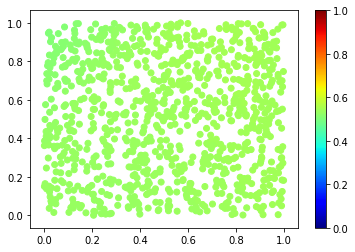

In [12]:
%matplotlib inline

NN_G.eval()
x_t, y_t = dataset[:1000]
y_pred = NN_G(x_t)
colormap = cm.jet
m = cm.ScalarMappable(cmap=colormap)
m.set_array(y[:,0])
colors = colormap(y_pred[:,0].detach().numpy())
plt.scatter(x_t[:, 0], x_t[:, 1], color=colors)
cb = plt.colorbar(m)
#cb.set_label('mean value')
